In [13]:
import os
import distutils.core
import torch
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import json
import sys

dist = distutils.core.run_setup("../detectron2/setup.py")
sys.path.insert(0, os.path.abspath('../detectron2'))

#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# import some common detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import fasttext

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler


import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transform
from torchvision.transforms import ToTensor

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

import matplotlib.pyplot as plt
import glob
import os
import sys
import numpy as np

import subprocess
import glob
from moviepy.editor import VideoFileClip

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler

from PIL import Image
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from sklearn.neighbors import KNeighborsClassifier

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
gen = torch.Generator()
gen.manual_seed(SEED)
pass

In [14]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [15]:
#load dataset
#annotations_path = "/export/home/group05/annotations/instances_val2014.json"
#database_path = "/export/home/group05/val2017/"
ROOT_PATH = '../datasets/MSCOCO'

annotations_path = f"{ROOT_PATH}/annotations/captions_val2014.json"
annotations_train_path = f"{ROOT_PATH}/annotations/instances_train2014.json"
database_path = f"{ROOT_PATH}/val2014/"
coco_annotation=COCO(annotations_path)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Num images train: 20252
Num images val: 20252
Num images test: 0
Captions: ['A woman straddling a surfboard in the water with a camera on the surfboard.', 'A beautiful young woman riding a surfboard in the ocean.', 'a woman on a red surfboard looking away from the camera', 'A woman sitting on a surfboard in the ocean.', 'The girl surfer is waiting to catch a wave.']


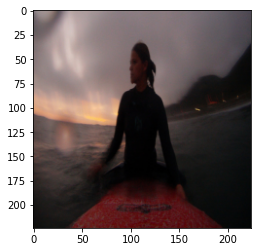

In [16]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
gen = torch.Generator()
gen.manual_seed(SEED)

# TODO - Check if normalization is correct for this dataset
# data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))])
# data_transform = transforms.Compose([transforms.ToTensor()])
# TODO - Check if we can avoid to reshape the input images
data_transform = transforms.Compose([transform.Resize((224, 224)),transforms.ToTensor()])

val_coco_dataset = torchvision.datasets.CocoCaptions(root=ROOT_PATH+"/val2014/", annFile=ROOT_PATH+'/annotations/captions_val2014.json', transform=data_transform)

num_samples = len(val_coco_dataset)
train_size = int(0.5 * num_samples)
val_size = int(0.5 * num_samples)
test_size = num_samples - train_size - val_size

train_coco_dataset, val_coco_dataset, test_coco_dataset = torch.utils.data.random_split(val_coco_dataset, [train_size, val_size, test_size])

print(f'Num images train: {len(train_coco_dataset)}')
print(f'Num images val: {len(val_coco_dataset)}')
print(f'Num images test: {len(test_coco_dataset)}')


image, target = val_coco_dataset[2]

plt.imshow(image.permute(1,2,0).numpy())
print(f'Captions: {target}')

In [17]:
class TripletDataset(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """
    def __init__(self, dataset, fasttext_model):
        self.dataset = dataset
        self.train = self.dataset.train
        self.transform = self.dataset.dataset.transform 
        self.len_dataset = len(self.dataset)
        self.fasttext_model = fasttext_model

    def __getitem__(self, index):
        positive_index = index
        positive_img, positive_captions = self.dataset[positive_index]
        positive_caption = np.random.choice(positive_captions)
        
        negative_index = -1
        while negative_index == -1 or negative_index == positive_index:
            negative_index = np.random.randint(0, self.len_dataset-1)
    
        negative_img, negative_captions = self.dataset[negative_index]
        negative_caption = np.random.choice(negative_captions)
        
        positive_img = Image.fromarray(np.uint8(positive_img.permute(1, 2, 0).numpy() * 255))
        negative_img = Image.fromarray(np.uint8(negative_img.permute(1, 2, 0).numpy() * 255))
            
        if self.transform is not None:
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        # Fastext cannot use multiple lines, just use one line at a time (replace \n by .)
        positive_caption = positive_caption.replace('\n', '')
        negative_caption = negative_caption.replace('\n', '')
        
        # if '\n' in positive_caption:
        #     print(positive_caption)
        #     print(repr(positive_caption))
        #     sys.exit()
        
        # if '\n' in negative_caption:
        #     print(' ---- ')
        #     print(negative_caption)
        #     print(repr(negative_caption))
        #     sys.exit()
        
        positive_caption = self.fasttext_model.get_sentence_vector(positive_caption)
        positive_caption = torch.from_numpy(np.array(positive_caption))
        
        negative_caption = self.fasttext_model.get_sentence_vector(negative_caption)
        negative_caption = torch.from_numpy(np.array(negative_caption))
            
        # Maybe change here, that if it is for evaluation we do not need to create the caption embeddings?
        if self.train:
            pass
        else:
            pass
        
        return (positive_caption, positive_img, negative_img), []

    def get_item_original(self, index):
        positive_index = index
        positive_img, positive_captions = self.dataset[positive_index]
        positive_caption = np.random.choice(positive_captions)
        
        negative_index = -1
        while negative_index == -1 or negative_index == positive_index:
            negative_index = np.random.randint(0, self.len_dataset-1)
    
        negative_img, negative_captions = self.dataset[negative_index]
        negative_caption = np.random.choice(negative_captions)
        
        positive_img = Image.fromarray(np.uint8(positive_img.permute(1, 2, 0).numpy() * 255))
        negative_img = Image.fromarray(np.uint8(negative_img.permute(1, 2, 0).numpy() * 255))
            
        if self.transform is not None:
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        if self.train:
            pass
        else:
            pass
        
        return (positive_caption, positive_img, negative_img), []
    
    def __len__(self):
        return len(self.dataset)

fasttext_model = fasttext.load_model('./fasttext_wiki.en.bin')

val_coco_dataset.train = False
triplet_val_coco_dataset = TripletDataset(val_coco_dataset, fasttext_model)

train_coco_dataset.train = True
triplet_train_coco_dataset = TripletDataset(train_coco_dataset, fasttext_model)
pass

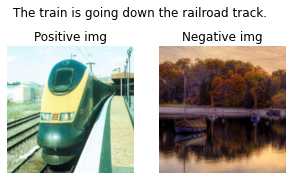

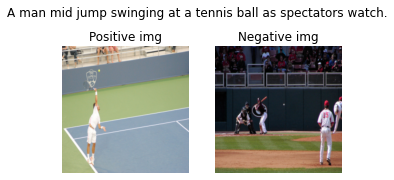

In [18]:
idx = 500

(caption, positive_img, negative_img), _ = triplet_val_coco_dataset.get_item_original(idx)
plt.figure(figsize=(5,3))
plt.suptitle(caption)

plt.subplot(1,2,1)
plt.axis('off')
plt.title('Positive img')
plt.imshow(positive_img.permute(1, 2, 0).numpy())

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Negative img')
plt.imshow(negative_img.permute(1, 2, 0).numpy())

plt.show()

idx = 321

(caption, positive_img, negative_img), _ = triplet_val_coco_dataset.get_item_original(idx)
plt.figure(figsize=(5,3))
plt.suptitle(caption)

plt.subplot(1,2,1)
plt.axis('off')
plt.title('Positive img')
plt.imshow(positive_img.permute(1, 2, 0).numpy())

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Negative img')
plt.imshow(negative_img.permute(1, 2, 0).numpy())

plt.show()

In [19]:
class ImageEmbeddingNet(nn.Module):
    def __init__(self, hidden_space=1000):
        super(ImageEmbeddingNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.hidden = nn.Linear(2048, hidden_space)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1).squeeze()
        x = self.hidden(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

class TextEmbeddingNet(nn.Module):
    def __init__(self, hidden_space=1000):
        super(TextEmbeddingNet, self).__init__()
        
        # We need to do projection here
        self.hidden = nn.Linear(300, hidden_space)

    def forward(self, x):
        x = self.hidden(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)
    
class TripletNet(nn.Module):
    def __init__(self, im_embedding_net, text_embedding_net):
        super(TripletNet, self).__init__()
        self.im_embedding_net = im_embedding_net
        self.text_embedding_net = text_embedding_net

    def forward(self, x1, x2, x3):
        caption_embedding = self.text_embedding_net(x1)
        pos_im_embedding = self.im_embedding_net(x2)
        neg_im_embedding = self.im_embedding_net(x3)
        return caption_embedding, pos_im_embedding, neg_im_embedding

    def get_embedding(self, x, is_image=False):
        if is_image:
            embedding = self.im_embedding_net(x)
        else:
            embedding = self.text_embedding_net(x)
        return embedding

In [20]:
# idx = 321

# (positive_img, positive_caption, negative_caption), _ = triplet_val_coco_dataset[idx]

# The space we want to project the embeddings to. This is just a linear transformation
hidden_space_dim = 1000

im_embedding_net = ImageEmbeddingNet(hidden_space_dim)
# im_tensor = torch.tensor(positive_img)  # creates a tensor with shape (1, 3, 224, 224)
# im_tensor = im_tensor.unsqueeze(0)
# im_embedding = im_embedding_net(im_tensor)

# print(f'Image embedding: {im_embedding.shape}')

text_embedding_net = TextEmbeddingNet(hidden_space_dim)

# positive_caption_embedding = text_embedding_net(positive_caption)
# negative_caption_embedding = text_embedding_net(negative_caption)

# print(f'Positive caption embedding: {positive_caption_embedding.shape}')
# print(f'Negative caption embedding: {negative_caption_embedding.shape}')

triplet_net = TripletNet(im_embedding_net, text_embedding_net)

In [21]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [22]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.get_device_name()
if cuda:
    triplet_net.cuda()
# Set up the network and training parameters
margin = 1.
loss_fn = TripletLoss(margin)
batch_size = 64
lr = 1e-3
optimizer = optim.Adam(triplet_net.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 150
log_interval = 10
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_coco_dataset, batch_size=batch_size, shuffle=True)
triplet_val_loader = torch.utils.data.DataLoader(triplet_val_coco_dataset, batch_size=batch_size, shuffle=False)

In [23]:
def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()

    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        
        if cuda:
            data = tuple(d.cuda() for d in data)
            
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)
        

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics

def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model
    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)

train = False

if train:
    train_losses, val_losses = fit(triplet_train_loader, triplet_val_loader, triplet_net, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
    print('Train losses:', train_losses)
    print('Val losses:', val_losses)
    torch.save(triplet_net.state_dict(), 'triplet_secret_task_b.pth')
else:
    triplet_net.load_state_dict(torch.load('triplet_secret_task_b.pth'))

In [24]:
load_train_embeddings = True

#the max length of coco captions is 253
max_length = 253
#allowed characters for one hot encoding
characters = "abcdefghijklmnopqrstuvwxyz0123456789 .,!?'()-—–[]$€£@#%&*"
len_characters = len(characters)

max_im_size = 224

if not load_train_embeddings:
    with torch.no_grad():
        triplet_net.eval()
        train_im_embeddings = np.zeros((len(triplet_train_loader.dataset), hidden_space_dim))
        train_text_labels =  np.zeros((len(triplet_train_loader.dataset), max_length*len_characters))
        train_text_embeddings = np.zeros((len(triplet_train_loader.dataset), hidden_space_dim))
            
        for idx in range(len(triplet_train_coco_dataset)):
            (caption, _, _), _ = triplet_train_coco_dataset.get_item_original(idx)
            (fasttext_em_caption, positive_im, _), _ = triplet_train_coco_dataset[idx]
            
            flattened_img= positive_im.cpu().numpy()
            #print(flattened_img.shape)
            
            flattened_img= flattened_img.flatten()
            
            #print(flattened_img.shape)

            positive_im = positive_im.unsqueeze(0)
            positive_im = positive_im.cuda()
            train_im_embeddings[idx, :] = triplet_net.get_embedding(positive_im, is_image=True).data.cpu().numpy()

            fasttext_em_caption = fasttext_em_caption.unsqueeze(0)
            fasttext_em_caption = fasttext_em_caption.cuda()
            train_text_embeddings[idx, :] = triplet_net.get_embedding(fasttext_em_caption, is_image=False).data.cpu().numpy()
            
            #one hot encoding of the captions
            caption = "".join(c for c in caption if c.lower() in characters)
            caption = caption.lower()   #captions are set to lower case
            one_hot_encoding = np.zeros((len(caption), len(characters)))

            # loop over each character in the string and set the corresponding
            # element in the one-hot encoding matrix to 1
            for i, c in enumerate(caption):
                j = characters.index(c)
                one_hot_encoding[i, j] = 1
            #flatten into 1 dimension
            one_hot_encoding = one_hot_encoding.flatten()
            
            # Pad the resulting vectors to a length of max_sentence_size*total_characters
            padded_texts = np.pad(one_hot_encoding, (0, len_characters*max_length - len(one_hot_encoding)), mode='constant', constant_values=0)

            train_text_labels[idx, :] = padded_texts
            
        with open('./task_embeddings_train_b.npy', 'wb') as f: 
            np.save(f, train_im_embeddings)
            np.save(f, train_text_embeddings)
            np.save(f, train_text_labels)
else:
    with open('./task_embeddings_train_b.npy', 'rb') as f:
        train_im_embeddings = np.load(f)
        train_text_embeddings = np.load(f)
        train_text_labels = np.load(f)

In [25]:
load_val_embeddings = True

#the max length of coco captions is 253
max_length = 253
#allowed characters for one hot encoding
characters = "abcdefghijklmnopqrstuvwxyz0123456789 .,!?'()-—–[]$€£@#%&*"
len_characters = len(characters)

max_im_size = 224

if not load_val_embeddings:
    with torch.no_grad():
        triplet_net.eval()
        val_im_embeddings = np.zeros((len(triplet_val_loader.dataset), hidden_space_dim))
        test_text_labels =  np.zeros((len(triplet_val_loader.dataset), max_length*len_characters))
        val_text_embeddings = np.zeros((len(triplet_val_loader.dataset), hidden_space_dim))
            
        for idx in range(len(triplet_val_coco_dataset)):
            (caption, _, _), _ = triplet_val_coco_dataset.get_item_original(idx)
            (fasttext_em_caption, positive_im, _), _ = triplet_val_coco_dataset[idx]
            
            flattened_img= positive_im.cpu().numpy()
            #print(flattened_img.shape)
            
            flattened_img= flattened_img.flatten()
            
            #print(flattened_img.shape)

            positive_im = positive_im.unsqueeze(0)
            positive_im = positive_im.cuda()
            val_im_embeddings[idx, :] = triplet_net.get_embedding(positive_im, is_image=True).data.cpu().numpy()

            fasttext_em_caption = fasttext_em_caption.unsqueeze(0)
            fasttext_em_caption = fasttext_em_caption.cuda()
            val_text_embeddings[idx, :] = triplet_net.get_embedding(fasttext_em_caption, is_image=False).data.cpu().numpy()
            
            #one hot encoding of the captions
            caption = "".join(c for c in caption if c.lower() in characters)
            caption = caption.lower()   #captions are set to lower case
            one_hot_encoding = np.zeros((len(caption), len(characters)))

            # loop over each character in the string and set the corresponding
            # element in the one-hot encoding matrix to 1
            for i, c in enumerate(caption):
                j = characters.index(c)
                one_hot_encoding[i, j] = 1
            #flatten into 1 dimension
            one_hot_encoding = one_hot_encoding.flatten()
            
            # Pad the resulting vectors to a length of max_sentence_size*total_characters
            padded_texts = np.pad(one_hot_encoding, (0, len_characters*max_length - len(one_hot_encoding)), mode='constant', constant_values=0)

            test_text_labels[idx, :] = padded_texts
            
        with open('./task_embeddings_val_b.npy', 'wb') as f: 
            np.save(f, val_im_embeddings)
            np.save(f, val_text_embeddings)
            np.save(f, test_text_labels)
else:
    with open('./task_embeddings_val_b.npy', 'rb') as f:
        val_im_embeddings = np.load(f)
        val_text_embeddings = np.load(f)
        test_text_labels = np.load(f)

In [26]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
print("KNN fit")
knn.fit(val_im_embeddings, test_text_labels)

KNN fit


KNeighborsClassifier()

In [27]:
distances, indices = knn.kneighbors(val_text_embeddings, return_distance = True)

# print("DISTANCES ", distances)
# print("INDICES ", indices)

In [58]:
def show_query(idx_query):
    top_5_indices = indices[idx_query,:5]
    top_5_ims = []
    
    (_, positive_im, _), _ = triplet_val_coco_dataset.get_item_original(idx_query)
    plt.imshow(positive_im.permute(1,2,0).numpy())
    plt.axis('off')
    plt.show()

    for idx in top_5_indices:
        (_, positive_im, _), _ = triplet_val_coco_dataset.get_item_original(idx)
        top_5_ims.append(positive_im)

    (text, _, _), _ = triplet_val_coco_dataset.get_item_original(idx_query)
    
    
    plt.figure(figsize=(12,3))
    plt.suptitle(text)

    for idx, im in enumerate(top_5_ims):
        plt.subplot(1, 5, idx+1)
        plt.axis('off')
        plt.imshow(np.uint8(im.permute(1,2,0).cpu().numpy()*255))

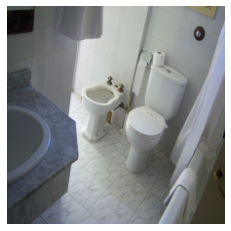

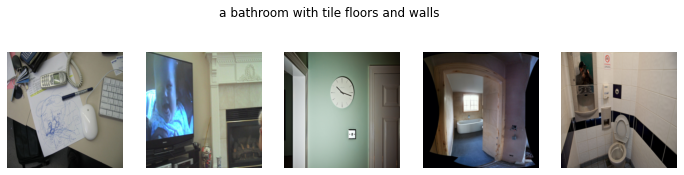

In [59]:
show_query(4502)